In [10]:
from IPython.display import display

In [6]:
import pandas as pd
# import cv2
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

In [3]:
spot_data = pd.read_csv("spot_dataset/spot_labels.csv")
spot_data

,image_name,lat,lon,known_features,spot_name
0,./spot_dataset/zuccotti_park.png,40.709360,-74.011790,stairs ledge,zuccotti_park
1,./spot_dataset/three_up_three_down.png,40.725248,-74.011773,stairs,three_up_three_down
2,./spot_dataset/columbus_circle.png,40.768116,-73.981823,ledge,columbus_circle
3,./spot_dataset/c_benches.png,40.705475,-74.005988,bench,c_benches
4,./spot_dataset/pyramid_ledges.png,40.704747,-74.008049,stairs ledge,pyramid_ledges
5,./spot_dataset/water_street_ledges_2.png,40.704546,-74.006341,bench,water_street_benches
6,./spot_dataset/water_street_ledges_2.png,40.704546,-74.006341,bench,water_street_benches
7,./spot_dataset/pine_street_ledges_2.png,40.705347,-74.006569,bench,pine_street_ledges
8,./spot_dataset/pine_street_ledges_1.png,40.705347,-74.006569,bench,pine_street_ledges


In [9]:
import moondream as md
# Initialize the model to run locally
model = md.vl(endpoint="http://localhost:2020/v1")

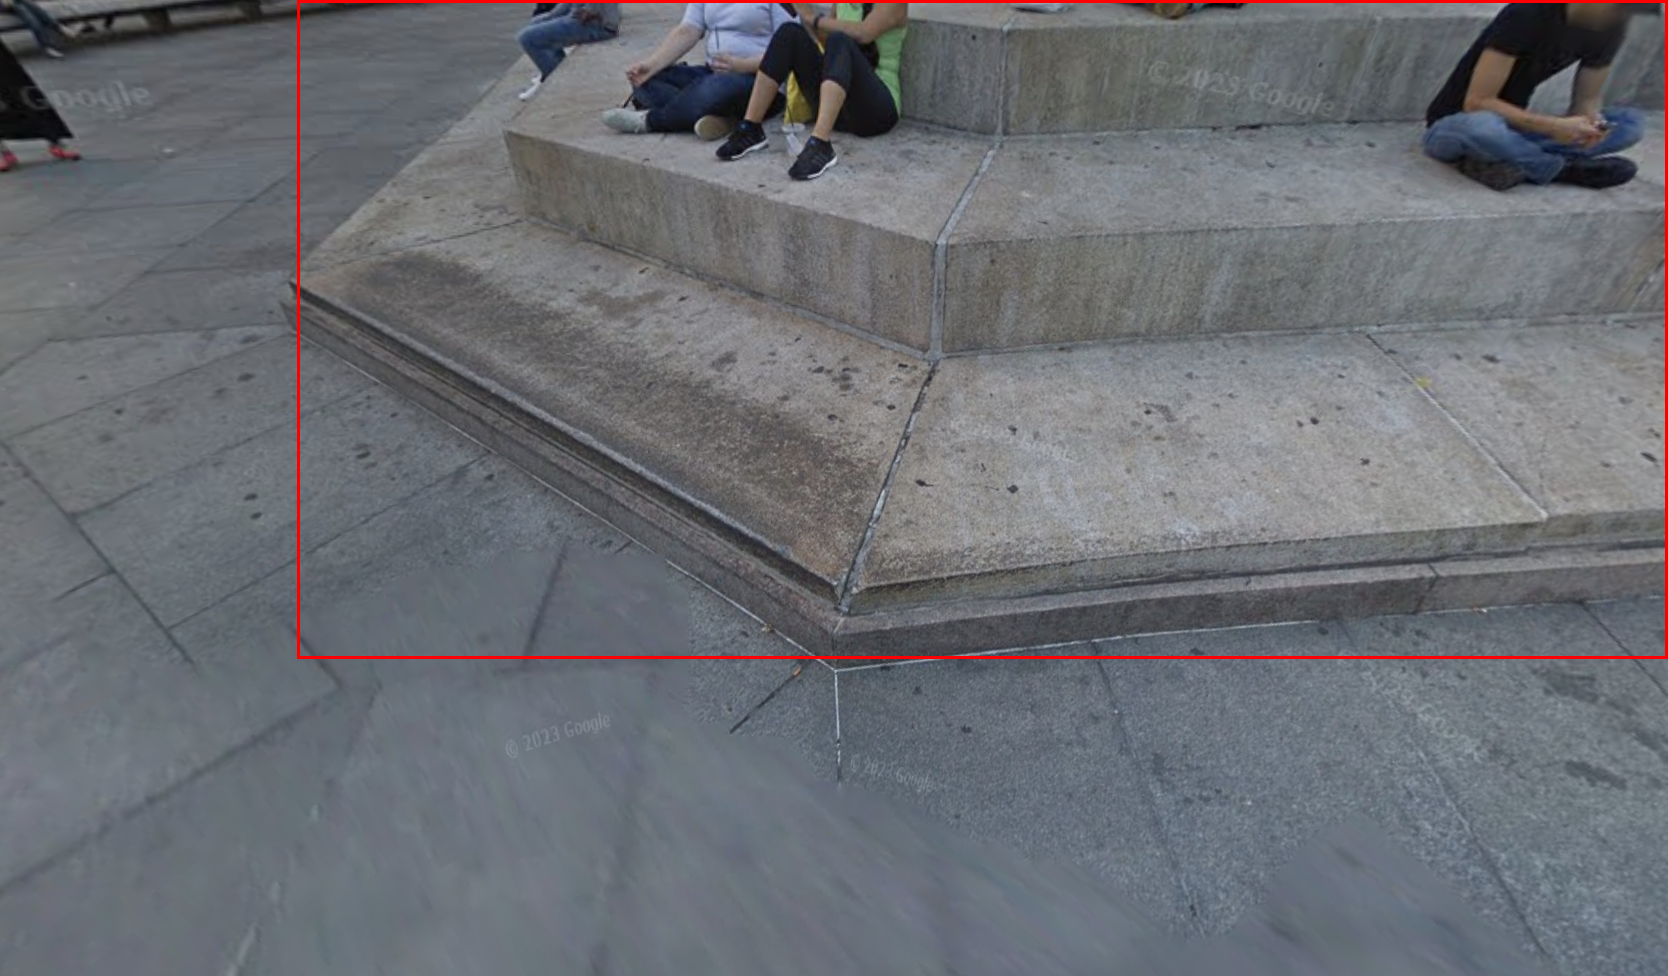

In [18]:
# image = cv2.imread(spot_data.iloc[7]['image_name'])
image = Image.open(spot_data.iloc[2]['image_name'])
caption = model.caption(image)['caption']
answer = model.query(image, "Are there stairs, ledges, or benches in the image?")['answer']
detection = model.detect(image, 'ledge stairs')['objects']
points = model.point(image, 'ledge and stairs')['points']
overlay = image.copy()
draw = ImageDraw.Draw(overlay)
w, h = overlay.size
for box in detection:
    draw.rectangle([
        int(box['x_min'] * w),
        int(box['y_min'] * h),
        int(box['x_max'] * w),
        int(box['y_max'] * h)
    ], outline='red', width=3)

display(overlay)

In [15]:
print("answer: " + answer)
print()
print("caption: " + caption)

answer:  Yes, there are benches in the image, which are located in a city plaza.

caption:  The image depicts a serene city plaza, bathed in the soft glow of sunlight. The plaza is paved with light gray stone tiles and features a concrete wall with a textured surface, possibly a brick or concrete pattern. A concrete bench is situated near the wall, and a tree stands tall in the center of the plaza. The plaza is surrounded by buildings, including a modern glass building and a brick building, with a portion of a white postal truck visible in the background. The image is taken from a low angle, emphasizing the height of the trees and the grandeur of the buildings. The ground is mostly shadowed, with the sunlight illuminating the stone surfaces and casting long shadows.


In [17]:
print("answer: " + answer)
print()
print("caption: " + caption)

answer:  Yes, there are stairs, ledges, and benches in the image.

caption:  The image captures a street corner in an urban setting. The street is paved with a mix of gray and reddish-brown bricks and features a crosswalk marked with white lines. A pedestrian is walking on the sidewalk, and a few other people are also visible in the distance. The street is lined with trees and buildings, including a tall, light-colored building with a blue sign that reads! "BUS STOP". The image is overlaid with a Google Street View perspective, indicated by the "Google" logo in the top right corner and the "Street View" icons in the bottom right corner. The street also features several manhole covers and planters along the sidewalk.


In [23]:
print("answer: " + answer)
print()
print("caption: " + caption)

answer:  Yes, there are stairs in the image, and people are sitting on them.

caption:  The image shows a stone structure, possibly a fountain or a similar public art piece, situated in a plaza. The structure is composed of multiple levels of gray stone steps, creating a stepped effect. Several people are seated on the steps, some appearing to be in conversation. The plaza is paved with gray stone tiles, and the overall scene is relatively calm. The image is taken from a low angle, emphasizing the height of the structure.


In [33]:
ans_1 = "Yes, there are benches in the image, which are located in a city plaza."
ans_2 = "Yes, there are stairs, ledges, and benches in the image."
ans_3 = "Yes, there are stairs in the image, and people are sitting on them."
ans_4 = "Yes, there is a bench in this image, and people are sitting on them." # simulated answer
x = []
if "benches" or "bench" in ans_2: 
    x.append("benches") 
if "stairs" in ans_2: 
    x.append("stairs") 
x

['benches', 'stairs']

In [29]:
path = spot_data.iloc[0]['image_name']
path.split('/')[-1].split('.')[0]

'zuccotti_park'

In [34]:
def process_spot_image(image_path, save_img=True): 
    """
    Return VLM prediction of skate spot features in the image and return hits for keywords
    Our list of keywords: BENCH, STAIRS, LEDGE
    Note: huge assumption in regularity of output which generally follows: 
    "Yes, there is *feature*, *feature*, and *feature*." 
    """
    image = Image.open(image_path)
    answer = model.query(image, "Are there stairs, ledges, or benches in the image?")['answer']
    detection = model.detect(image, 'ledge stairs')['objects']
    overlay = image.copy()
    draw = ImageDraw.Draw(overlay)
    w, h = overlay.size
    for box in detection:
        draw.rectangle([
            int(box['x_min'] * w),
            int(box['y_min'] * h),
            int(box['x_max'] * w),
            int(box['y_max'] * h)
        ], outline='red', width=3)
    
    if save_img: 
        output_path = "./output/" + image_path.split('/')[-1].split('.')[0] + "output.png"
        Image.save(output_path)

    features = []
    if "benches" or "bench" in answer: 
        features.append("benches")
    if "stairs" in answer: 
        features.append("stairs")
    if "ledges" or "ledge" in answer: 
        features.append("ledges") 
    
    return features


In [35]:
def batch_process_spots(df):
    results = []
    for idx, row in df.iterrows():
        print(f"Processing {row['spot_name']}...")
        detected = process_spot_image(row['image_name'])
        results.append({
            'spot_name': row['spot_name'],
            'known_features': row['known_features'].split(),
            'detected_features': detected,
            'lat': row['lat'],
            'lon': row['lon']
        })
    return results

In [ ]:
dummy_results = [{'spot_name': 'pyramid_ledges',
                  'known_features': 'stairs ledges benches',
                  'detected_features': 'stairs ledges benches',
                  'lat': ]

In [20]:
import folium